# Project 3

Import some libraries and the datasets

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from ISLP import load_data, confusion_table
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier)
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics


# main dataset
data_index_2 = pd.read_csv('../Project_datasets/data_index_2.csv')
# no idea what this is
#data_index_example = pd.read_csv('../Project_datasets/data_index - example.csv')
LPJ_GUESS_output = pd.read_csv('../Project_datasets/LPJ-GUESS_output_BERN1.csv')
# precipitation by day and statistics
Predaymean = pd.read_csv('../Project_datasets/Predaymean1961_1990.csv')
Predaymean_statistics = pd.read_csv('../Project_datasets/Predaymean1961_1990_statics.csv')
# maximum temperature by day and statistics
Tmaxdaymean = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990.csv')
Tmaxdaymean_statistics = pd.read_csv('../Project_datasets/Tmaxdaymean1961_1990_statics.csv')
# minimum temperature by day and statistics
Tmindaymean = pd.read_csv('../Project_datasets/Tmindaymean1961_1990.csv')
Tmindaymean_statistics = pd.read_csv('../Project_datasets/Tmindaymean1961_1990_statics.csv')
# mean temperature by day and statistics
Tmpdaymean = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990.csv')
Tmpdaymean_statistics = pd.read_csv('../Project_datasets/Tmpdaymean1961_1990_statics.csv')
# shortwave radiation flux
Tswrfdaymean = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990.csv')
Tswrfdaymean_statistics = pd.read_csv('../Project_datasets/Tswrfdaymean1961_1990_statics.csv')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Text file

In [2]:
gridlist_pan_gfed_ISO3_UN = open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt','r')

Show the first entries

### Main Data set

Short legend about the colums: 

Lon: Longitude<br>
Lat: Latidude

stuff about the souil texture: <br>

clay: Clay in %<br>
silt: Silt in % (sedimentary deposit that is formed when a river deposits the material it is carrying)<br>
slay: slay in %(soil in eg. rainforest) <br>
sand: sand in % %<br>
orC: organic carbondioxid in %<br>
CN: Cyanide in %<br>
pH: pH<br>
cell fraction: portion of cells / organic material in soil in % <br>


Allways with season: Same as the tables below.

tmax: maximum temperatur in K <br>
tmin: min temperature in K <br>
tmp:mean temperature in K <br>
Pre: Precipitation, mm day-1 <br>
tswrf: Total shortwave radiation flux, W m-2


This is the GUESS output: 

NPP: net primary productivity (kg C m-2 year-1)<br>
SoilR: soil respiration (kg C m-2 year-1)<br>
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)<br>
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)<br>
VegC: Vegetation carbon poo (kg C m-2)l<br>
LitterC: Litter carbon pool (kg C m-2)<br>
SoilC: Soil carbon pool (kg C m-2)<br>
Biome_Cmass: The biome type based on the maximum biomass (category)<br>
Biome_LAI: The biome type based on the maximum LAI (category)<br>
Biome_obs: The observed biome type (category)<br>

Country codes

GFED-region: Global Fire Emissions Database (https://www.un-spider.org/global-fire-emissions-database-gfed) <br>
Pan_2007: Big reogion (Europa, Africa, Australia, USA, Russia, China, .... )<br>
ISO3: Abbreviation for country <br>
UN: Country code

In [3]:
print(f'shape: {data_index_2.shape}')
data_index_2.head()

shape: (59191, 84)


,Unnamed: 0,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
0,0,-179.75,71.25,0.08,0.37,0.55,0.020,11.0,5.9,0.482,...,0.0,0.000,0.000,13,13,17,10,'Russia','RUS',643
1,1,-179.75,68.75,0.20,0.48,0.32,0.031,17.0,6.3,0.753,...,0.0,0.003,0.015,13,11,17,10,'Russia','RUS',643
2,2,-179.75,68.25,0.20,0.48,0.32,0.031,17.0,6.3,0.447,...,0.0,0.006,0.022,13,11,17,10,'Russia','RUS',643
3,3,-179.75,67.75,0.20,0.48,0.32,0.031,17.0,6.3,0.526,...,0.0,0.002,0.020,13,11,17,10,'Russia','RUS',643
4,4,-179.75,67.25,0.20,0.48,0.32,0.031,17.0,6.3,0.422,...,0.0,0.003,0.016,13,11,17,10,'Russia','RUS',643


In [4]:
with open("../Project_datasets/Readme.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if False:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

data information:
1. There are five climate variables which are daily average values during 1961-1990. They are Tswrf (Total shortwave radiation flux, W m-2), Pre (Precipitation, mm day-1), Tmp (Daily mean temperature, K), 
Tmax (Daily maximum temperature, K), and Tmin (Daily minimum temperature, K). 

2. In the file LPJ-GUESS_output BERN1.csv, the following variables are collected:
NPP: net primary productivity (kg C m-2 year-1)
SoilR: soil respiration (kg C m-2 year-1)
MaxBiomeCmass: The maximum biomass from a single biome (kg C m-2)
MxbiomeLAI: The maximum leaf area index from a single biome (unitless)
VegC: Vegetation carbon poo (kg C m-2)l
LitterC: Litter carbon pool (kg C m-2)
SoilC: Soil carbon pool (kg C m-2)
Biome_Cmass: The biome type based on the maximum biomass (category)
Biome_LAI: The biome type based on the maximum LAI (category)
Biome_obs: The observed biome type (category)

3. legend of biome

4. soilmap_center_interpolated.dat: the texture inforamtion for each grid ce

### LPJ_Guess_output


In [5]:
print(f'shape: {LPJ_GUESS_output.shape}')
LPJ_GUESS_output.head()

shape: (59191, 12)


,Lon,Lat,NPP,SoilR,MaxBiomeCmax,MaxBiomeLAI,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs
0,39.75,-1.25,0.429,0.390,0.449,1.9821,1.225,0.758,5.941,8,12,12
1,150.25,-34.25,0.554,0.451,6.883,3.3174,6.953,3.221,10.566,7,7,6
2,-63.75,82.75,0.000,0.000,0.000,0.0000,0.000,0.003,0.002,13,13,17
3,59.25,30.75,0.043,0.042,0.090,0.2146,0.127,0.084,0.543,7,11,14
4,24.25,27.75,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,13,13,17


### Pred (Precipitation, mm day-1)
 

In [6]:
print(f'shape: {Predaymean.shape}')
Predaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,0.634400,0.838580,1.373300,1.487800,0.948640,0.705560,0.790570,0.69274,...,1.260600,1.011600,2.676200,2.146300,0.83299,0.97611,1.092800,2.015100,1.220200,1.064100
1,150.25,-34.25,3.176800,3.282800,4.271300,2.735100,3.118300,1.863200,2.245400,1.81270,...,1.243100,2.901500,1.580400,2.788500,3.62270,2.12350,2.546700,2.624700,1.521800,2.259400
2,-63.75,82.75,0.191720,0.553370,0.559100,0.350270,0.414340,0.239620,0.215600,0.39415,...,0.286600,0.187410,0.352480,0.303120,0.37439,0.29827,0.399200,0.162680,0.180370,0.251560
3,59.25,30.75,0.272920,0.576200,1.529900,0.475970,0.809060,0.772860,0.773340,0.12219,...,0.315400,0.223630,0.009584,0.004932,0.65535,1.25430,0.680690,0.534400,0.225750,0.281360
4,24.25,27.75,0.012822,0.044511,0.027133,0.003318,0.007306,0.014162,0.085964,0.01347,...,0.029099,0.040272,0.030631,0.000518,0.00058,0.12653,0.010889,0.002139,0.003662,0.009687


In [7]:
print(f'shape: {Predaymean_statistics.shape}')
Predaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,0.870380,0.693390,0.641700,1.622500,1.30490,1.11930,0.528780,0.450650,0.315910,2.049600,1.836000,1.289100
1,150.25,-34.25,3.251700,2.971600,1.559000,2.418500,2.07100,1.51770,1.725700,1.331900,1.054600,2.547500,2.358200,1.253600
2,-63.75,82.75,0.234270,0.209640,0.139210,0.333730,0.31885,0.18320,0.758070,0.735040,0.338730,0.325480,0.296160,0.154960
3,59.25,30.75,0.715820,0.592520,0.423350,0.136010,0.03079,0.17825,0.005847,0.000000,0.020282,0.180990,0.045619,0.278850
4,24.25,27.75,0.045284,0.015422,0.070006,0.061916,0.01050,0.10039,0.004480,0.000016,0.022542,0.028823,0.006414,0.055641


### Tmp (Daily mean temperature, K)

In [8]:
print(f'shape: {Tmpdaymean.shape}')
Tmpdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,301.11,301.14,301.07,300.95,301.14,301.32,301.33,301.33,...,301.49,301.63,301.19,301.11,301.15,301.39,301.33,301.40,301.49,301.39
1,150.25,-34.25,293.59,293.28,293.53,292.33,292.28,292.75,292.78,293.84,...,293.04,292.88,292.75,293.03,292.37,292.62,293.36,292.90,293.58,292.72
2,-63.75,82.75,241.33,242.18,242.51,241.94,241.99,241.18,240.35,240.29,...,242.67,243.21,244.22,243.65,242.88,241.99,243.01,243.91,244.09,243.10
3,59.25,30.75,281.13,281.06,281.34,282.07,281.57,281.56,282.13,282.14,...,283.05,282.85,282.33,281.68,281.74,281.59,281.69,281.00,281.42,281.48
4,24.25,27.75,285.84,285.50,285.25,285.06,284.62,285.04,285.01,284.48,...,285.96,285.78,285.66,285.68,285.39,285.57,285.62,285.71,285.71,285.66


In [9]:
print(f'shape: {Tmpdaymean_statistics.shape}')
Tmpdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,302.34,302.33,0.6554,301.21,301.20,1.3120,299.60,299.65,0.46193,301.42,301.39,0.44815
1,150.25,-34.25,292.82,292.97,1.1691,284.64,284.10,2.7774,282.29,281.50,1.80220,289.77,289.76,2.17460
2,-63.75,82.75,240.12,240.07,1.2096,260.31,261.44,10.1770,271.20,274.13,5.88880,247.77,245.76,4.80570
3,59.25,30.75,285.40,284.89,3.3975,299.63,300.13,4.0871,302.39,303.13,2.64690,288.71,287.35,4.84480
4,24.25,27.75,287.69,287.32,2.6203,299.53,299.15,2.9706,301.97,302.61,1.34370,291.17,290.75,4.37740


### Tmax

In [10]:
print(f'shape: {Tmaxdaymean.shape}')
Tmaxdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,302.63,302.91,302.83,302.43,302.76,302.99,302.95,303.04,...,302.96,303.14,302.65,302.49,302.66,302.87,302.73,302.76,302.99,302.98
1,150.25,-34.25,296.43,296.09,295.97,294.85,294.73,295.55,295.77,296.80,...,296.44,296.16,295.83,296.28,295.14,295.86,296.45,296.14,296.54,294.66
2,-63.75,82.75,244.72,245.60,245.89,245.11,244.98,244.50,243.61,243.90,...,246.04,246.82,247.53,247.26,246.58,246.02,246.67,247.49,247.69,246.57
3,59.25,30.75,284.75,284.92,285.61,286.23,285.53,285.78,286.21,285.91,...,287.97,288.04,287.38,286.80,287.24,287.00,286.86,286.56,286.61,286.65
4,24.25,27.75,290.05,289.76,289.50,289.10,289.05,289.41,289.26,288.84,...,290.04,289.73,289.58,289.62,289.48,289.77,289.97,290.24,290.17,289.90


In [11]:
print(f'shape: {Tmaxdaymean_statistics.shape}')
Tmaxdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,304.27,304.43,0.74315,302.40,302.40,1.0318,301.13,301.11,0.39706,302.66,302.62,0.4142
1,150.25,-34.25,295.36,295.46,1.20660,288.11,287.64,3.0125,285.74,284.94,1.78200,293.06,293.14,2.1944
2,-63.75,82.75,243.87,243.72,1.14260,263.31,264.06,9.1992,272.13,274.69,5.69120,250.88,249.34,4.3383
3,59.25,30.75,288.82,287.81,3.27200,304.98,306.09,4.5394,307.99,308.63,2.57240,294.33,293.13,5.0202
4,24.25,27.75,291.96,291.66,2.65600,303.90,303.83,3.3008,306.28,306.87,1.23550,295.48,295.23,4.3877


### Tmin

In [12]:
print(f'shape: {Tmindaymean.shape}')
Tmindaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,296.63,296.49,296.55,296.51,296.69,296.64,296.68,296.74,...,296.54,296.48,296.30,296.23,296.26,296.29,296.46,296.43,296.55,296.83
1,150.25,-34.25,290.14,289.85,289.86,288.98,288.74,289.37,289.22,290.43,...,289.51,289.81,289.54,289.99,289.32,289.53,290.06,289.90,290.14,289.41
2,-63.75,82.75,240.80,241.47,241.86,241.37,241.49,240.74,239.82,239.64,...,241.86,242.46,243.48,242.96,242.10,241.31,242.23,243.03,242.98,242.13
3,59.25,30.75,278.46,278.36,278.70,279.43,279.03,279.01,279.38,279.36,...,278.97,278.82,278.43,278.07,277.74,277.97,277.98,277.51,277.71,277.86
4,24.25,27.75,284.46,283.98,283.83,283.46,283.21,283.67,283.66,283.15,...,284.47,284.35,284.12,284.14,283.96,284.09,284.21,284.29,284.28,284.57


In [13]:
print(f'shape: {Tmindaymean_statistics.shape}')
Tmindaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,298.06,298.41,0.85947,297.03,297.02,0.77132,295.42,295.38,0.19342,296.47,296.48,0.32203
1,150.25,-34.25,288.99,289.28,1.23520,280.58,280.14,2.60160,278.59,277.94,2.10780,286.79,287.04,2.03760
2,-63.75,82.75,239.70,239.61,1.13850,259.44,260.53,10.01100,268.84,272.09,5.76450,246.56,244.91,4.44050
3,59.25,30.75,282.46,281.83,3.41820,297.17,298.07,3.95480,299.81,300.63,2.58780,285.18,283.81,5.08320
4,24.25,27.75,285.68,285.31,2.18730,296.19,296.15,2.91960,298.87,299.31,1.03790,289.35,289.10,4.03760


### Tswrf (Total shortwave radiation flux, W m-2)

In [14]:
print(f'shape: {Tswrfdaymean.shape}')
Tswrfdaymean.head()

shape: (59191, 367)


,Lon,Lat,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,...,Day356,Day357,Day358,Day359,Day360,Day361,Day362,Day363,Day364,Day365
0,39.75,-1.25,231.59,219.87,236.62,238.73,239.37,250.71,236.94,236.88,...,205.60,223.60,195.67,198.74,203.09,193.82,210.05,199.19,223.03,220.83
1,150.25,-34.25,306.97,311.71,310.55,311.11,311.43,304.95,312.76,312.54,...,305.95,301.99,296.33,301.22,287.30,293.39,301.39,296.81,296.34,279.91
2,-63.75,82.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,59.25,30.75,133.78,137.99,136.90,126.10,145.59,132.06,136.92,132.72,...,145.09,125.97,127.70,125.30,137.31,113.15,117.91,131.45,134.91,128.61
4,24.25,27.75,144.89,153.19,155.81,165.83,163.23,163.97,153.20,162.64,...,144.84,150.68,153.20,151.03,158.60,153.69,153.10,160.78,152.35,146.26


In [15]:
print(f'shape: {Tswrfdaymean_statistics.shape}')
Tswrfdaymean_statistics.head()

shape: (59191, 14)


,Lon,Lat,SpringMean,SpringMedian,SpringStd,SummerMean,SummerMedian,SummerStd,FallMean,FallMedian,FallStd,WinterMean,WinterMedian,WinterStd
0,39.75,-1.25,245.3500,243.31,12.278,224.76,223.69,14.020,212.13,209.70,17.828,230.61000,233.69,13.8210
1,150.25,-34.25,273.2400,280.66,31.715,143.77,134.31,30.976,168.57,159.00,40.282,277.94000,279.75,26.3640
2,-63.75,82.75,6.8325,0.00,14.407,214.38,238.73,68.931,140.85,142.78,85.973,0.43718,0.00,1.5824
3,59.25,30.75,176.1900,170.71,37.004,312.30,323.65,34.345,286.04,287.80,31.122,160.32000,153.34,34.7040
4,24.25,27.75,207.9700,200.82,38.315,308.44,311.95,20.496,302.93,307.45,23.021,189.10000,185.46,32.6170


### County List and binome legend

In [24]:
headers = 'Lon', 'Lat', 'GFED-region', 'Pan_2007', 'OSO3', 'UN'  # Column names.

# Read the data from file into a list-of-lists table.
with open('../Project_datasets/gridlist_pan_gfed_ISO3_UN.txt') as file:
    datatable = [line.split() for line in file.read().splitlines()]

# Find the longest data value or header to be printed in each column.
widths = [max(len(value) for value in col)
            for col in zip(*(datatable + [headers]))]

# Print heading followed by the data in datatable.
# (Uses '>' to right-justify the data in some columns.)
format_spec = '{:{widths[0]}}  {:>{widths[1]}}  {:>{widths[2]}} {:>{widths[3]}} {:>{widths[4]}} {:>{widths[5]}}'
#print(format_spec.format(*headers, widths=widths))
for fields in datatable:
    print(format_spec.format(*fields, widths=widths))

Lon         Lat  GFED-region    Pan_2007 ISO3  UN
-69.75   -55.25            5    Americas  CHL 152
-69.25   -55.25            5    Americas  CHL 152
-71.25   -54.75            5    Americas  CHL 152
-70.75   -54.75            5    Americas  CHL 152
-70.25   -54.75            5    Americas  CHL 152
-69.75   -54.75            5    Americas  CHL 152
-69.25   -54.75            5    Americas  CHL 152
-68.75   -54.75            5    Americas  CHL 152
-68.25   -54.75            5    Americas  ARG  32
-67.75   -54.75            5    Americas  ARG  32
-67.25   -54.75            5    Americas  ARG  32
-66.75   -54.75            5    Americas  ARG  32
-66.25   -54.75            5    Americas  ARG  32
-65.75   -54.75            5    Americas  ARG  32
-72.25   -54.25            5    Americas  CHL 152
-71.75   -54.25            5    Americas  CHL 152
-71.25   -54.25            5    Americas  CHL 152
-70.75   -54.25            5    Americas  CHL 152
-70.25   -54.25            5    Americas  CHL 152


-116.75   52.75            1      Canada  CAN 124
-116.25   52.75            1      Canada  CAN 124
-115.75   52.75            1      Canada  CAN 124
-115.25   52.75            1      Canada  CAN 124
-114.75   52.75            1      Canada  CAN 124
-114.25   52.75            1      Canada  CAN 124
-113.75   52.75            1      Canada  CAN 124
-113.25   52.75            1      Canada  CAN 124
-112.75   52.75            1      Canada  CAN 124
-112.25   52.75            1      Canada  CAN 124
-111.75   52.75            1      Canada  CAN 124
-111.25   52.75            1      Canada  CAN 124
-110.75   52.75            1      Canada  CAN 124
-110.25   52.75            1      Canada  CAN 124
-109.75   52.75            1      Canada  CAN 124
-109.25   52.75            1      Canada  CAN 124
-108.75   52.75            1      Canada  CAN 124
-108.25   52.75            1      Canada  CAN 124
-107.75   52.75            1      Canada  CAN 124
-107.25   52.75            1      Canada  CAN 124


In [18]:
    
with open("../Project_datasets/legend of biomes.txt",'r') as script:
    speech = script.read().splitlines()

count = 1
for line in speech:
    if True:
        count+=1
        if count % 2 == 0: #this is the remainder operator
            print(line)
    else:
        print(line)

1 Boreal decid forest
2 Boreal ever forest
3 Temp/boreal mix fo.
4 Temp conifer forest
5 Temp decid forest
6 Temp broad ever fo.
7 Temp mixed forest
8 Trop season forest
9 Trop rain forest
10 Trop decid forest
11 Moist savannas
12 Dry savannas
13 Tall grassland
14 Dry grassland
15 Xeric wood/shrub
16 Arid shrub/steppe
17 Desert
18 Arctic/alpine tundra


## Section 2: Visualisation


In [25]:
print(data_index_2.describe())

         Unnamed: 0           Lon           Lat          clay          silt  \
count  59191.000000  59191.000000  59191.000000  59191.000000  59191.000000   
mean   29595.000000     20.469932     30.797541      0.226424      0.280915   
std    17087.114229     85.694107     31.484488      0.106558      0.109771   
min        0.000000   -179.750000    -55.250000      0.040000      0.050000   
25%    14797.500000    -63.250000      7.750000      0.170000      0.200000   
50%    29595.000000     30.250000     37.750000      0.230000      0.300000   
75%    44392.500000     93.750000     57.250000      0.270000      0.330000   
max    59190.000000    179.750000     83.250000      0.540000      0.610000   

               sand          orgC            CN            pH  cellfraction  \
count  59191.000000  59191.000000  59190.000000  59190.000000  59190.000000   
mean       0.492662      0.022554     12.038250      6.329958      0.520901   
std        0.165724      0.056028      2.444517    

Countplot to count the number of data for each biom: 

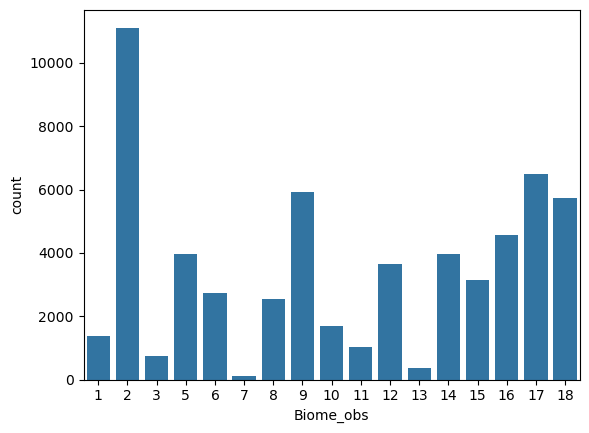

In [57]:
# create lineplot 
g = sns.countplot(data_index_2, x = "Biome_obs")
  
# set the ticks first 
#g.set_xticks(np.arange(1,19, 1)) 
  
# set the labels 
#g.set_xticklabels(['2011', '2012', '2013', '2014',  '2015', '2016', '2017', '2018']) 

Scatter plott - Biome_LAI: The biome type based on the maximum LAI (category)

<Axes: xlabel='MaxBiomeLAI', ylabel='Biome_obs'>

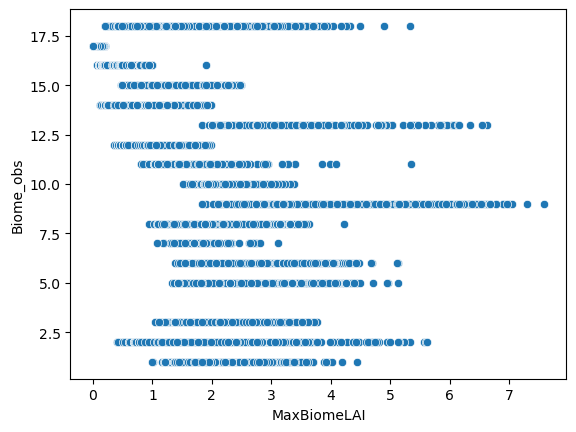

In [64]:
sns.scatterplot(data_index_2, x = "MaxBiomeLAI", y = "Biome_obs")

Scatterplott - Biome_Cmass: The biome type based on the maximum biomass (category)

<Axes: xlabel='MaxBiomeCmax', ylabel='Biome_obs'>

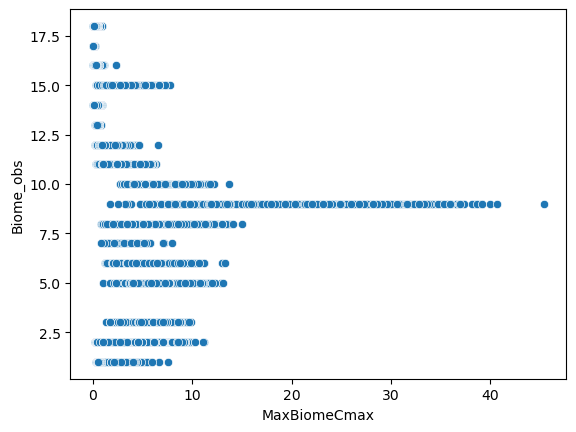

In [65]:
sns.scatterplot(data_index_2, x = "MaxBiomeCmax", y = "Biome_obs")

<Axes: xlabel='Lon', ylabel='Lat'>

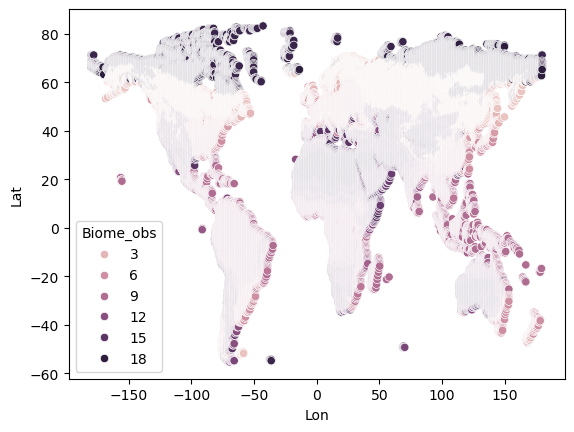

In [62]:
sns.scatterplot(data_index_2, x="Lon", y="Lat", hue="Biome_obs")

## Section 3: Binarz Classification

Choose countries. Random.org gave us the biomes
- 14: Dry grassland
- 17: Desert

In [23]:
biome_list = [17,14] # our chosen ones

fineness = 'ISO3' #'Pan_2007'
biome_countries = data_index_2[fineness].drop_duplicates()
for biome_nbr in biome_list:
    # print(data_index_2.loc[data_index_2.loc[data_index_2['Pan_2007'].isin(biome_countries)]['Biome_obs'].isin([biome_nbr])]['Pan_2007'].drop_duplicates())
    relevant_countries = data_index_2.loc[data_index_2[fineness].isin(biome_countries)]
    biome_countries = relevant_countries.loc[relevant_countries['Biome_obs']==biome_nbr][fineness].drop_duplicates()
print(f'the following countries are relevant:\n{biome_countries}')
# select two random countries
chosen_countries = [stats.randint.rvs(0,len(biome_countries)-1) for i in range(2)]
print(chosen_countries)
chosen_countries = [biome_countries.iloc[chosen_county] for chosen_county in chosen_countries]
for chosen_country in chosen_countries:
    print(f'We choose 2 random countries: {chosen_country}')
# stats.randint.rvs(0,len(biome_countries)-1)
# set countries to Egypt and China
chosen_countries = ['EGY','CHN']

the following countries are relevant:
2258     'CAN'
2862     'USA'
10015    'PER'
12200    'CHL'
12563    'ARG'
18638       []
18655    'MRT'
18871    'MAR'
19022    'MLI'
19355    'DZA'
20857    'NER'
22086    'CHE'
22098    'TUN'
22508    'ITA'
22640    'LBY'
23188    'NAM'
23710    'TCD'
27259    'SDN'
27616    'EGY'
33089    'SOM'
39973    'CHN'
42776    'RUS'
Name: ISO3, dtype: object
[2, 1]
We choose 2 random countries: 'PER'
We choose 2 random countries: 'USA'


Thus we choose Egypt to train and China as test.

In [20]:
# NaN appears in table, see where it occurs
print(list(data_index_2.loc[:,data_index_2.isna().any()]))
data_index_2[data_index_2.isna().any(axis=1)]

['CN', 'pH', 'cellfraction']


,Unnamed: 0,Lon,Lat,clay,silt,sand,orgC,CN,pH,cellfraction,...,VegC,LitterC,SoilC,Biome_Cmax,Biome_LAI,Biome_obs,GFED-region,Pan_2007,ISO3,UN
59182,59182,179.75,71.25,0.08,0.37,0.55,0.02,NaN,NaN,NaN,...,0.0,0.0,0.001,13,13,17,0,[],[],0


In [ ]:
# restrict to two biomes, restrict to country codes, remove any rows with NaN
relevant_data = data_index_2.loc[data_index_2['Biome_obs'].isin(biome_list)] # restrict to two biomes

FixedFormatter should only be used together with FixedLocator


[Text(0, 0, "'RUS'"),
 Text(1, 0, '[]'),
 Text(2, 0, "'USA'"),
 Text(3, 0, "'CAN'"),
 Text(4, 0, "'MEX'"),
 Text(5, 0, "'PER'"),
 Text(6, 0, "'CHL'"),
 Text(7, 0, "'ARG'"),
 Text(8, 0, "'BOL'"),
 Text(9, 0, "'MRT'"),
 Text(10, 0, "'SEN'"),
 Text(11, 0, "'MAR'"),
 Text(12, 0, "'MLI'"),
 Text(13, 0, "'DZA'"),
 Text(14, 0, "'BFA'"),
 Text(15, 0, "'NER'"),
 Text(16, 0, "'CHE'"),
 Text(17, 0, "'TUN'"),
 Text(18, 0, "'ITA'"),
 Text(19, 0, "'LBY'"),
 Text(20, 0, "'AGO'"),
 Text(21, 0, "'NAM'"),
 Text(22, 0, "'TCD'"),
 Text(23, 0, "'NOR'"),
 Text(24, 0, "'SWE'"),
 Text(25, 0, "'ZAF'"),
 Text(26, 0, "'BWA'"),
 Text(27, 0, "'SDN'"),
 Text(28, 0, "'EGY'"),
 Text(29, 0, "'ZWE'"),
 Text(30, 0, "'KEN'"),
 Text(31, 0, "'ETH'"),
 Text(32, 0, "'ERI'"),
 Text(33, 0, "'SOM'"),
 Text(34, 0, "'DJI'"),
 Text(35, 0, "'CHN'"),
 Text(36, 0, "'AUS'")]

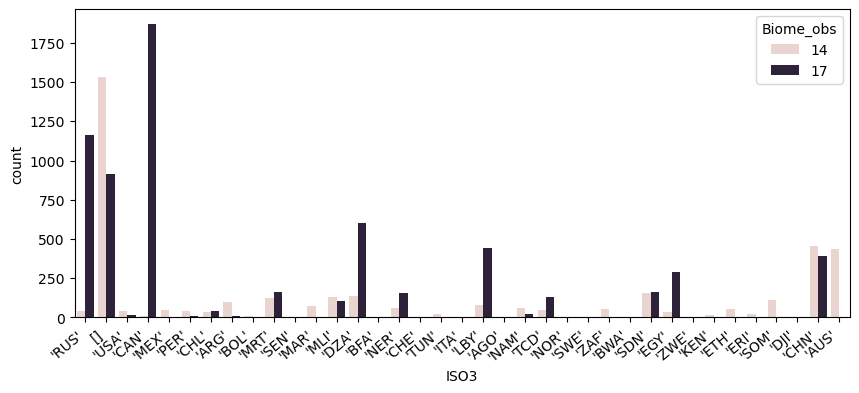

In [76]:


fig, ax = plt.subplots(figsize=(10,4))
ax = sns.countplot( relevant_data, x = 'ISO3', hue = 'Biome_obs')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [ ]:
sns.histplot(data, x="", hue="biome", ax=axs[0])

In [21]:
relevant_data = relevant_data[~(relevant_data.isna().any(axis=1))] # delete rows with NaN
relevant_data_train = relevant_data.loc[relevant_data['ISO3']==f"'{chosen_countries[0]}'"] # restrict to training country
relevant_data_test = relevant_data.loc[relevant_data['ISO3']==f"'{chosen_countries[1]}'"] # restrict to test country

drop_columns = ['Biome_obs','Biome_LAI','Biome_Cmax','Lon','Lat','Pan_2007','ISO3','UN'] # drop these columns
X_train = relevant_data_train.drop(columns=drop_columns)
X_test = relevant_data_test.drop(columns=drop_columns)
feature_names = list(X_train.columns)

Y_train = relevant_data_train['Biome_obs']==biome_list[0] # give True if it is the first biome in the list
Y_test = relevant_data_test['Biome_obs']==biome_list[0] # give True if it is the first biome in the list

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)

# kfold3 = skm.KFold(3,
#                   random_state=1,
#                   shuffle=True) # let's try fewer fold to save running time
# n_depths_range = np.linspace(1, 10, 10).astype('int')
# n_estimators_range = np.linspace(10, 100, 10).astype('int') # CV number of trees (estimators) 10, 20, ..., 100

# params = {
#     'max_depth': n_depths_range, # let's tune for only one parameters to save running time
#     'n_estimators': n_estimators_range,
#      }
# rfc_gscv = GridSearchCV(clf, param_grid = params, scoring = "accuracy",
#                              cv = kfold3 )
# # Fit the model
# model_rfc = rfc_gscv.fit(X_train, Y_train)

# Some performance 
score_rfc_train = accuracy_score(Y_train, clf.predict(X_train))
print('Accuracy of RandomForestClassifier on train data: {:.4f}'.format(score_rfc_train))

# scores_rfc_val = cross_val_score(clf, X_train, High_train, cv=kfold)
# print("Accuracy RandomForestClassifier on cross validation: %0.4f ( %0.2f)" % (scores_rfc_val.mean(), scores_rfc_val.std()))

score_rfc_test = accuracy_score(Y_test, clf.predict(X_test))
print('Accuracy of RandomForestClassifier on test data: {:.4f}'.format(score_rfc_test))

Accuracy of RandomForestClassifier on train data: 1.0000
Accuracy of RandomForestClassifier on test data: 0.9953


## Section 4: Multiclass classification

## Section 5: Regression 